# CNN training

In [1]:
import os
import re
import copy
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pandas as pd

import PIL
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn

from __future__ import print_function
#import keras
from tensorflow import keras
import keras.preprocessing
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

import function_dl as func_dl
import function as func

%load_ext autoreload
%autoreload 2

Tensorflow version 2.2.0
Tensorflow version 2.2.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Processing

In [3]:
img_width, img_height = 224, 224
seed = 2021

- For two classes

In [ ]:
# ## For rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_del_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_del_image_info.list'

# ## For rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_dup_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_dup_image_info.list'

# ## For splited rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del_splits.list'

# ## For splited rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup_splits.list'

In [ ]:
# true_cnv_df  = pd.read_csv(true_file,  header=0,sep='\t')
# false_cnv_df = pd.read_csv(false_file, header=0,sep='\t')

In [ ]:
# true_images_path_list  = true_cnv_df['image_path']
# false_images_path_list = false_cnv_df['image_path']

In [ ]:
## For file with image path only:

# true_list = [each_file[0] for each_file in fileToList(true_file)]
# false_list = [each_file[0] for each_file in fileToList(false_file)]
# len(true_list), len(false_list)

- For three classes

In [ ]:
## For rare CNVs
# path = '/home/rt2776/cnv_espresso/images_rare_3classes/0-entire_cnv_file_list/'
# true_del_file  = path + 'true_del_image_info.list'
# false_del_file = path + 'false_del_image_info.list'

# true_dup_file  = path + 'true_dup_image_info.list'
# false_dup_file = path + 'false_dup_image_info.list'

# true_del_df  = pd.read_csv(true_del_file,  header=0,sep='\t')
# false_del_df = pd.read_csv(false_del_file, header=0,sep='\t')

# true_dup_df  = pd.read_csv(true_dup_file,  header=0,sep='\t')
# false_dup_df = pd.read_csv(false_dup_file, header=0,sep='\t')

# true_del_images_path_list  = true_del_df['image_path']
# false_del_images_path_list = false_del_df['image_path']

# true_dup_images_path_list  = true_dup_df['image_path']
# false_dup_images_path_list = false_dup_df['image_path']

In [ ]:
# ## For splited rare CNVs
# cnv_path_file = '/home/rt2776/cnv_espresso/images_rare_3classes/0-split_cnv_file.list'
# cnv_path_df = pd.read_csv(cnv_path_file, header = None, sep='\t')
# cnv_path_df.columns = ['path','label']
# cnv_path_list = cnv_path_df['path']
# combined_label= cnv_path_df['label']

In [ ]:
## For file with image path only:

# true_list = [each_file[0] for each_file in fileToList(true_file)]
# false_list = [each_file[0] for each_file in fileToList(false_file)]
# len(true_list), len(false_list)

In [ ]:
true_del_images_path_list.shape, false_del_images_path_list.shape, true_dup_images_path_list.shape, false_dup_images_path_list.shape

### Loading images from list to numpy array

In [ ]:
# # entire cnv
# true_del_img_np = loadImgs(true_del_images_path_list, img_width, img_height)
# true_del_img_np.shape

# false_del_img_np = loadImgs(false_del_images_path_list, img_width, img_height)
# false_del_img_np.shape

# true_dup_img_np = loadImgs(true_dup_images_path_list, img_width, img_height)
# true_dup_img_np.shape

# false_dup_img_np = loadImgs(false_dup_images_path_list, img_width, img_height)
# false_dup_img_np.shape

In [ ]:
# split CNV
# combined_img_np = func_dl.loadImgs(cnv_path_list, img_width, img_height)
combined_img_np.shape

### Generate labels for entire CNVs

In [ ]:
# Four classes
true_del_label = [0 for i in range(0,len(true_del_img_np))]
false_del_label = [1 for i in range(0,len(false_del_img_np))]

true_dup_label = [3 for i in range(0,len(true_dup_img_np))]
false_dup_label = [2 for i in range(0,len(false_dup_img_np))]

print(true_del_label[0:5], false_del_label[0:5], true_dup_label[0:5], false_dup_label[0:5])
print(len(true_del_label), len(false_del_label), len(true_dup_label), len(false_dup_label))

In [ ]:
# Three classes
true_del_label = [0 for i in range(0,len(true_del_img_np))]
false_del_label = [1 for i in range(0,len(false_del_img_np))]

true_dup_label = [2 for i in range(0,len(true_dup_img_np))]
false_dup_label = [1 for i in range(0,len(false_dup_img_np))]

print(true_del_label[0:5], false_del_label[0:5], true_dup_label[0:5], false_dup_label[0:5])
print(len(true_del_label), len(false_del_label), len(true_dup_label), len(false_dup_label))

### Combine true & false data for entire CNVs

In [ ]:
combined_cnv_info_df = true_del_df.append(false_del_df, ignore_index=True)
combined_cnv_info_df = combined_cnv_info_df.append(true_dup_df, ignore_index=True)
combined_cnv_info_df = combined_cnv_info_df.append(false_dup_df, ignore_index=True)

In [ ]:
combined_img_np = np.vstack((true_del_img_np, false_del_img_np, true_dup_img_np, false_dup_img_np))

In [ ]:
combined_img_np.shape

In [ ]:
combined_label = true_del_label + false_del_label + true_dup_label + false_dup_label

In [ ]:
len(combined_label)

### Backup or restore

In [5]:
backup_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/'
# os.makedirs(backup_path, exist_ok=True)

- Backup

In [ ]:
## Backup

# project_name = 'rare_entire_del'
# combined_cnv_info_df.to_csv(backup_path+'rare_del_entire_cnv_info.csv')
# np.save(backup_path+'rare_del_entire_img', combined_img_np)
# np.save(backup_path+'rare_del_entire_label', combined_label)

# project_name = 'rare_entire_dup'
# combined_cnv_info_df.to_csv(backup_path+'rare_entire_dup_info.csv')
# np.save(backup_path+'rare_entire_dup_img', combined_img_np)
# np.save(backup_path+'rare_entire_dup_label', combined_label)

# project_name = 'rare_entire_cnv'
# combined_cnv_info_df.to_csv(backup_path+'rare_entire_cnv_info.csv')
# np.save(backup_path+'rare_entire_cnv_img', combined_img_np)
# np.save(backup_path+'rare_entire_cnv_label_'+str(len(np.unique(combined_label)))+'classes', combined_label)

In [ ]:
## Backup for split CNVs

# project_name = 'rare_split_cnv_3classes'
# np.save(backup_path + project_name + '_label', cnv_label_list)
# np.save(backup_path + project_name + '_img_np', combined_img_np)

- Restore

In [6]:
## Restore for entire del or dup

# project_name = 'rare_entire_del'
# project_name = 'rare_entire_dup'
project_name = 'rare_entire_cnv'
nClasses = 3
if project_name == 'rare_entire_del' or project_name == 'rare_entire_dup' or project_name == 'rare_entire_cnv':
    combined_img = np.load(backup_path + project_name + '_img.npy')
    combined_label = np.load(backup_path+'rare_entire_cnv_label_'+str(nClasses)+'classes'+ '.npy')
    combined_cnv_info_df = pd.read_csv(backup_path+project_name+'_info.csv')

In [ ]:
## Restore for split del or dup

# project_name = 'rare_split_del'
# project_name = 'rare_split_dup'

# if project_name == 'rare_split_del' or project_name == 'rare_split_dup':
#     combined_img_np = np.load(backup_path + project_name + '_img.npy')
#     combined_label  = np.load(backup_path + project_name + '_label.npy')
#     try:
#         del combined_cnv_info_df
#     except:
#         pass

# project_name = 'rare_split_cnv_3classes'
# combined_label  = np.load(backup_path + project_name + '_label.npy')
# combined_img_np = np.load(backup_path + project_name + '_img_np.npy')

In [7]:
print("Project: '%s' dataset loaded."%project_name)
print("  -- Shape of image array: ", combined_img.shape)
print("  -- Shape of label      : ", combined_label.shape)
try:
    print("  -- Shape of CNV info   : ", combined_cnv_info_df.shape)
except:
    print("There is no CNV info data for split del or dup.")

Project: 'rare_entire_cnv' dataset loaded.
  -- Shape of image array:  (22008, 224, 224, 3)
  -- Shape of label      :  (22008,)
  -- Shape of CNV info   :  (22008, 22)


### Visulize training and testing dataset
- In order to check the performance in different size categories (number of windows/targets), we need to check the distribution of CNVs in training and testing set.

## Normalization

In [8]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = combined_img.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

The shape of input tensor: (224, 224, 3)


In [9]:
# Change to float datatype
combined_img = combined_img.astype('float32')

# Scale the data to lie between 0 to 1
combined_img /= 255

# Change the labels from integer to categorical data
combined_label_one_hot = to_categorical(combined_label)

## Find the unique numbers from the train labels

In [10]:
classes = np.unique(combined_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
print("4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")

Total number of outputs :  3
Output classes :  [0 1 2]
4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup


In [10]:
#np.where(train_label==0)

0
[[1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [0.7058824 0.7058824 0.7058824]
 [0.5372549 0.5372549 0.5372549]]


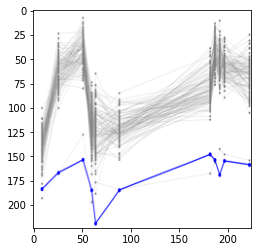

In [11]:
item = random.randint(0,len(combined_label))
item = 110 
print(combined_label[item])
func_dl.showImg(combined_img[item])
print(combined_img[item][100][0:10])

## Train the deep nerual model by Hold-out validation
- Ref: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
### Split dataset into training(80%) and testing(20%) dataset

In [12]:
## split image arrays
if project_name == 'rare_entire_cnv' or project_name == 'rare_entire_del' or project_name == 'rare_entire_dup':
    train_img, test_img, train_label, test_label, train_cnv_info_df, test_cnv_info_df = train_test_split(combined_img,
                                                                                                        combined_label_one_hot,
                                                                                                        combined_cnv_info_df,
                                                                                                        test_size=0.2,
                                                                                                        shuffle=True,
                                                                                                        random_state=seed)

    train_img, val_img, train_label, val_label, train_cnv_info_df, val_cnv_info_df = train_test_split(train_img,
                                                                                                      train_label,
                                                                                                      train_cnv_info_df,
                                                                                                      test_size=0.25,
                                                                                                      shuffle=True,
                                                                                                      random_state=seed) # 0.25*0.8=0.2

combined_img.shape, train_img.shape, val_img.shape, test_img.shape
combined_label_one_hot.shape, train_label.shape, val_label.shape, test_label.shape

((22008, 3), (13204, 3), (4402, 3), (4402, 3))

In [13]:
## split image arrays for splits CNVs
if project_name == 'rare_split_del' or project_name == 'rare_split_dup':
    train_img, test_img, train_label, test_label = train_test_split(combined_np,
                                                                    combined_label,
                                                                    test_size=0.2,
                                                                    shuffle=True,
                                                                    random_state=3)

    train_img, val_img, train_label, val_label = train_test_split(train_img,
                                                                  train_label,
                                                                  test_size=0.25,
                                                                  shuffle=True,
                                                                  random_state=3) # 0.25*0.8=0.2

if project_name == 'rare_split_cnv_3classes':
    train_img, test_img, train_label, test_label = train_test_split(combined_np,
                                                                    combined_label_one_hot,
                                                                    test_size=0.2,
                                                                    shuffle=True,
                                                                    random_state=3)

    train_img, val_img, train_label, val_label  = train_test_split(train_img,
                                                                  train_label,
                                                                  test_size=0.25,
                                                                  shuffle=True,
                                                                  random_state=3) # 0.25*0.8=0.2

Label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup
[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [0.99607843 0.99607843 0.99607843]
 [0.94509804 0.94509804 0.94509804]
 [0.9607843  0.9607843  0.9607843 ]
 [1.         1.         1.        ]
 [0.93333334 0.93333334 0.93333334]
 [0.9490196  0.9490196  0.9490196 ]
 [0.9490196  0.9490196  0.9490196 ]
 [0.9254902  0.9254902  0.9254902 ]
 [0.96862745 0.96862745 0.96862745]
 [1.         1.         1.        ]
 [0.7294118  0.7294118  0.7294118 ]
 [0.49411765 0.49411765 0.49411765]
 [0.8392157  0.8392157  0.8392157 ]
 [0.89411765 0.89411765 0.89411765]
 [0.8980392  0.8980392  0.8980392 ]
 [0.9529412  0.9529412  0.9529412 ]
 [1.         1.         1.        ]]


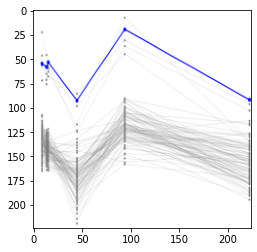

In [16]:
i=random.randrange(len(train_img))
## if the the images are different, then it means it has been shuffled.
print("Label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
func_dl.showImg(train_img[i]),train_label[i]#,train_cnv_info_df.iloc[i,:],train_cnv_info_df.iloc[i,20]
print(train_img[i][100][80:100])

In [17]:
test_img.shape, test_label.shape, test_cnv_info_df.shape

((4402, 224, 224, 3), (4402, 3), (4402, 22))

In [18]:
np.min(test_cnv_info_df['NUM_TARGETS']), np.max(test_cnv_info_df['NUM_TARGETS'])

(1, 513)

In [45]:
test_cnv_info_df[test_cnv_info_df['NUM_TARGETS']<4]

,Unnamed: 0,CHR,PRED_START,PRED_END,TYPE,SAMPLE,CANOES_RT,CLAMMS_RT,XHMM_RT,NUM_OVERLAPS_RT,...,PRED_SIZE,MAP,NUM_TARGETS,SIZE_LABEL,LABEL_VAL,ref,batch,Num_Carriers(inGivenCohort),Num_Targets_Wins,image_path
8119,8119,6,27400370,27456921,DUP,SP0029239,1.0,1.00,1.0,3,...,56551,1.00,3,F)50KB-75KB,1,hg38,spark3,1,6,/home/rt2776/cnv_espresso/images_rare_3classes...
17649,17649,17,41836342,41837588,DUP,SP0040215,0.0,0.00,1.0,1,...,1246,1.00,3,B)1KB-5KB,0,hg38,spark3,56,3,/home/rt2776/cnv_espresso/images_rare_3classes...
6045,6045,4,129093069,129106647,DEL,SP0125643,1.0,0.00,0.0,1,...,13578,1.00,3,D)10KB-25KB,0,hg38,spark9,0,3,/home/rt2776/cnv_espresso/images_rare_3classes...
6958,6958,13,75537381,75537805,DUP,SP0013148,0.0,1.00,1.0,2,...,424,1.00,3,A)<1KB,1,hg38,spark1,136,3,/home/rt2776/cnv_espresso/images_rare_3classes...
13987,13987,5,178120177,178122001,DUP,SP0107699,0.0,1.00,1.0,2,...,1824,1.00,3,B)1KB-5KB,1,hg38,spark9,1,3,/home/rt2776/cnv_espresso/images_rare_3classes...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9370,9370,19,57813293,57819946,DUP,SP0044377,0.0,0.81,1.0,2,...,6653,0.97,3,C)5KB-10KB,1,hg38,spark4,110,3,/home/rt2776/cnv_espresso/images_rare_3classes...
1812,1812,9,113049361,113056688,DEL,SP0046136,1.0,1.00,1.0,3,...,7327,1.00,3,C)5KB-10KB,1,hg38,spark4,34,3,/home/rt2776/cnv_espresso/images_rare_3classes...
11197,11197,6,32641309,32642764,DUP,SP0066994,0.0,0.00,1.0,1,...,1455,0.94,3,B)1KB-5KB,1,hg38,spark6,2,3,/home/rt2776/cnv_espresso/images_rare_3classes...
6051,6051,3,48576248,48576557,DEL,SP0126058,0.0,0.00,1.0,1,...,309,1.00,3,A)<1KB,0,hg38,spark9,0,3,/home/rt2776/cnv_espresso/images_rare_3classes...


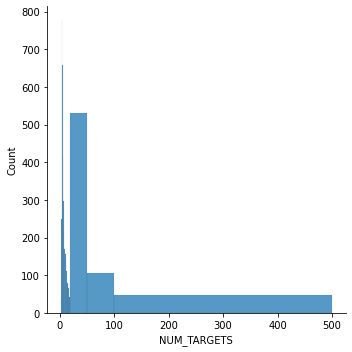

In [50]:
sns.displot(test_cnv_info_df, x="NUM_TARGETS",bins=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,50,100,500])

In [21]:
model_dir = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/'

common CNN

In [ ]:
model_name='CNN_model'
print("Model name: %s"%model_name)
model = cnn_model(model_name, nClasses)
model.summary()

In [ ]:
print("Training by a common CNN model ...")
batch_size = 30
epochs = 50
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc]) ## easy to exhaust the memory by using "validation_split = 0.2"

loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
# output model metrics
output_file = model_dir + "model_metrics_" + model_name + ".txt"
output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file)

- MobileNet v1

In [305]:
model_name='MobileNet_v1'
print("Model name: %s"%model_name)
model = func_dl.cnn_model(model_name, nClasses)
model.summary()
func.showDateTime()

Model name: MobileNet_v1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1000)              4253864   
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 1539      
Total params: 4,767,915
Trainable params: 4,746,027
Non-trainable params: 21,888
_________________________________________________________________
[2021.02.19-09:26:59]


In [22]:
model_name='MobileNet_v1_classic_tsf'
model = func_dl.transfer_learning_model("MobileNet_v1",nClasses,trainable=True)
model.summary()

Model name: MobileNet_v1, nClasses: 3, Trainable: True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [368]:
print("Training by MobileNet_v1 model ...")
batch_size = 100
epochs = 10
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

Training by MobileNet_v1 model ...
Epoch 1/10
132/133 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9955 - f1_m: 0.9955 - precision_m: 0.9955 - recall_m: 0.9955
Epoch 00001: val_accuracy improved from -inf to 0.90527, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_classic_tsf_3classes.h5
133/133 [==============================] - 74s 554ms/step - loss: 0.0142 - accuracy: 0.9955 - f1_m: 0.9955 - precision_m: 0.9956 - recall_m: 0.9955 - val_loss: 0.6023 - val_accuracy: 0.9053 - val_f1_m: 0.8962 - val_precision_m: 0.8966 - val_recall_m: 0.8958
Epoch 2/10
132/133 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9939 - f1_m: 0.9939 - precision_m: 0.9939 - recall_m: 0.9939
Epoch 00002: val_accuracy improved from 0.90527 to 0.91913, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_classic_tsf_3classes.h5
133/133 [===

In [369]:
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

Model_name: MobileNet_v1_classic_tsf
loss: 0.678913414478302 
accuracy: 0.9104952216148376 
f1_score: 0.9107285737991333 
precision: 0.9110403060913086 
recall: 0.9104267358779907


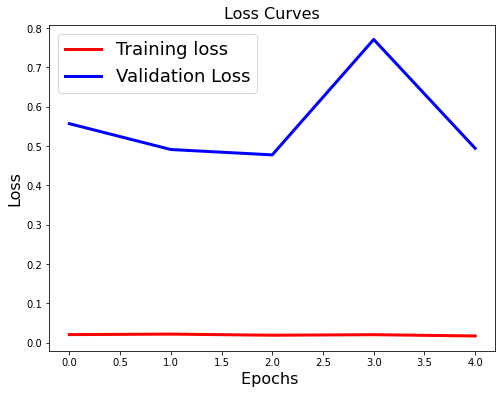

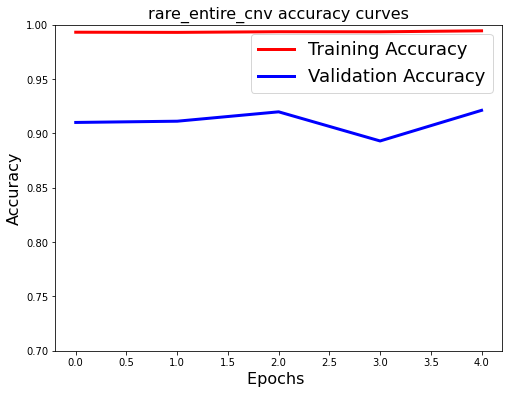

In [365]:
func_dl.draw_loss_accuracy_curves(history, project_name)


--- Confusion matrix for test data ---

3 classes label: 0-True del; 1-True dip; 2-True dup


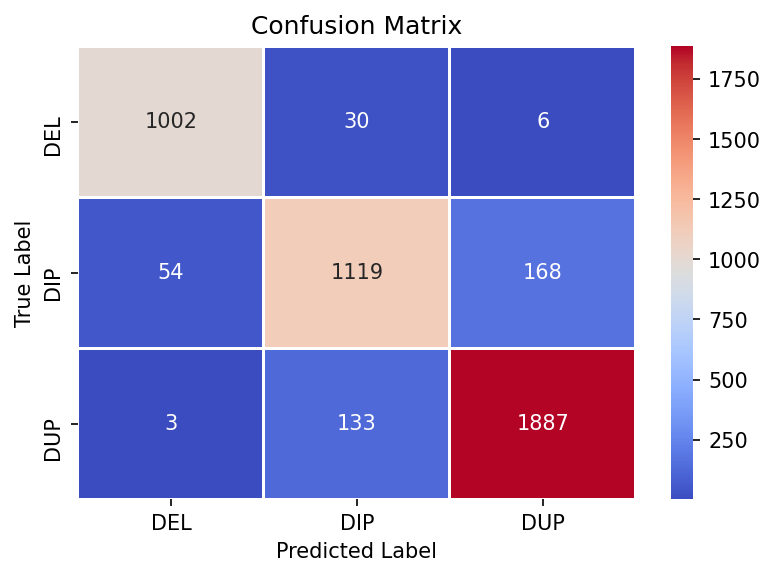


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1038
           1       0.87      0.83      0.85      1341
           2       0.92      0.93      0.92      2023

    accuracy                           0.91      4402
   macro avg       0.91      0.91      0.91      4402
weighted avg       0.91      0.91      0.91      4402



In [370]:
func_dl.confusion_matrix(model, test_img, test_label, nClasses)

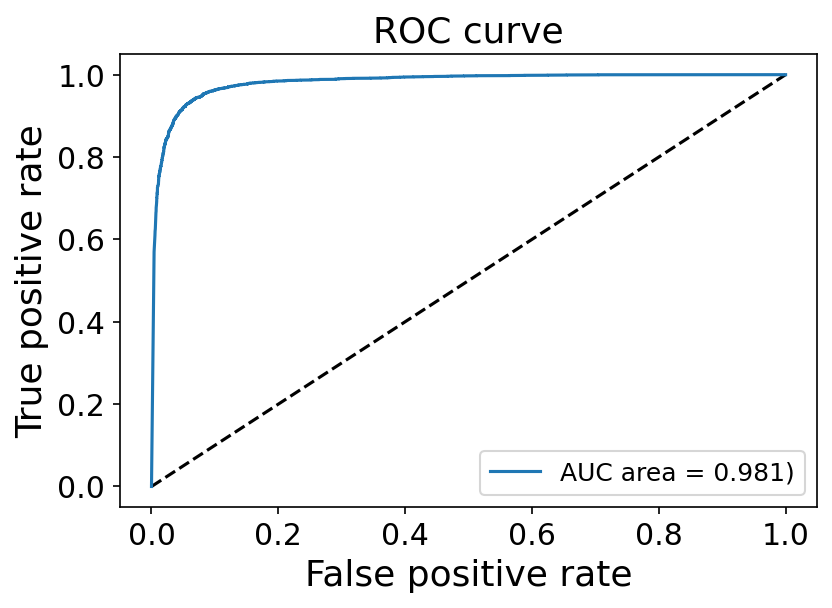

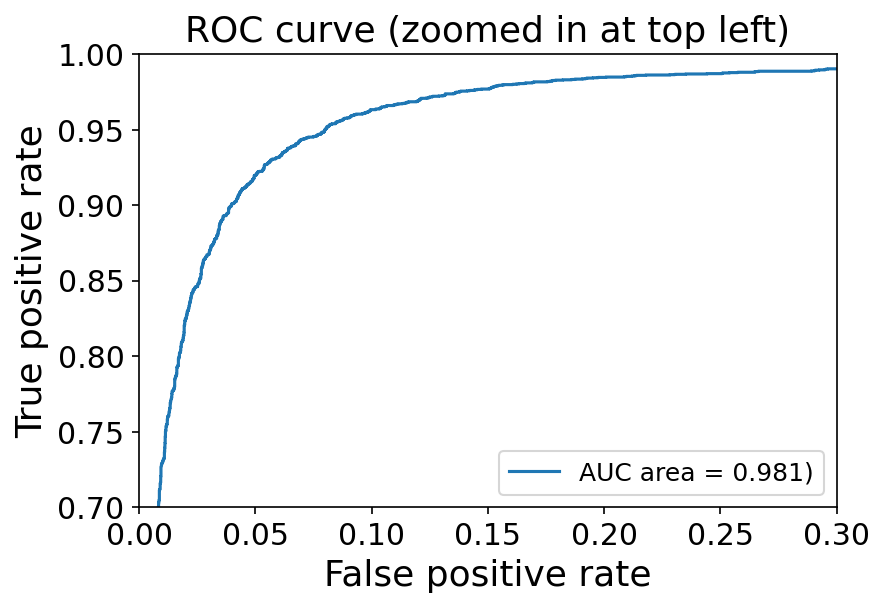

In [372]:
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

In [ ]:
# output model metrics
output_file = model_dir + project_name + "_" + model_name + "_model_metrics.txt"
output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file)
func.showDateTime()

- transfer learning and fine-tuning

In [33]:
model_name='MobileNet_v1_fine-tuning'
base_model = tf.keras.applications.MobileNet(
weights='imagenet',  # Load weights pre-trained model.
input_shape=(224, 224, 3),    #input_shape=(224, 224, 3),
include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3)) #keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nClasses,activation='softmax')(x)      
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,075
Non-trainable params: 3,228,864
_________________________________________________________________


In [35]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', func_dl.f1_m, func_dl.precision_m, func_dl.recall_m])

In [51]:
print("Training by MobileNet_v1 model ...")
batch_size = 32
epochs = 20
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

Training by MobileNet_v1 model ...
Epoch 1/20
413/413 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9438 - f1_m: 0.9439 - precision_m: 0.9448 - recall_m: 0.9430
Epoch 00001: val_accuracy improved from -inf to 0.88914, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5
413/413 [==============================] - 79s 190ms/step - loss: 0.1434 - accuracy: 0.9438 - f1_m: 0.9439 - precision_m: 0.9448 - recall_m: 0.9430 - val_loss: 0.2768 - val_accuracy: 0.8891 - val_f1_m: 0.8894 - val_precision_m: 0.8903 - val_recall_m: 0.8885
Epoch 2/20
413/413 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9520 - f1_m: 0.9517 - precision_m: 0.9522 - recall_m: 0.9513
Epoch 00002: val_accuracy improved from 0.88914 to 0.92299, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5
413/413 [===


--- Confusion matrix for test data ---

3 classes label: 0-True del; 1-True dip; 2-True dup


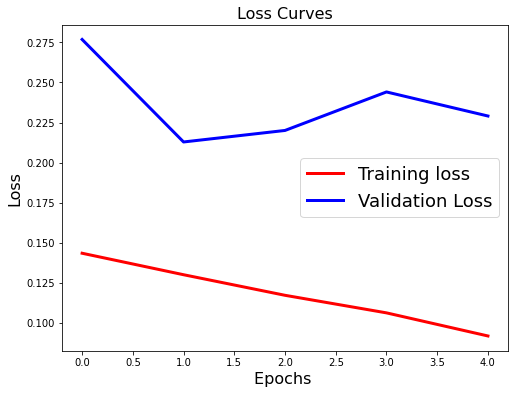

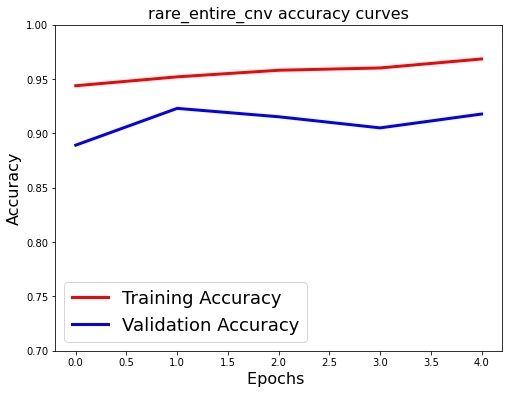

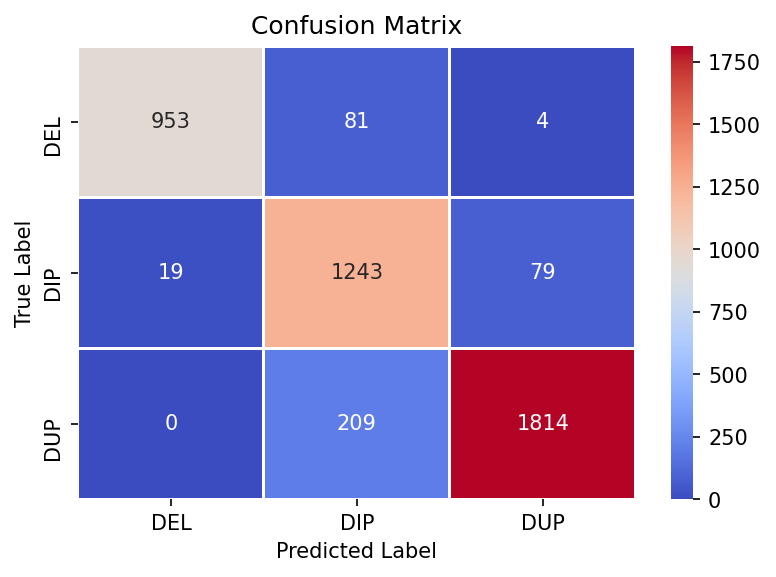


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1038
           1       0.81      0.93      0.86      1341
           2       0.96      0.90      0.93      2023

    accuracy                           0.91      4402
   macro avg       0.92      0.91      0.91      4402
weighted avg       0.92      0.91      0.91      4402



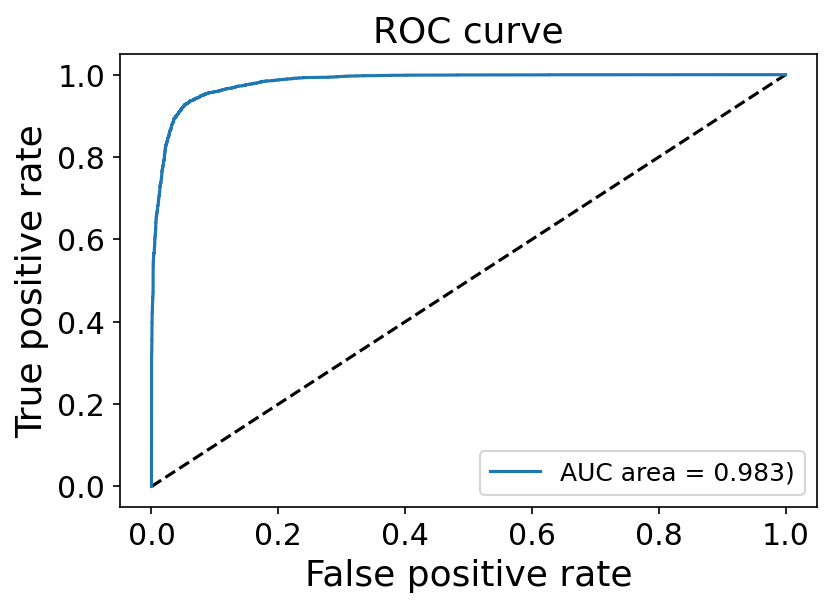

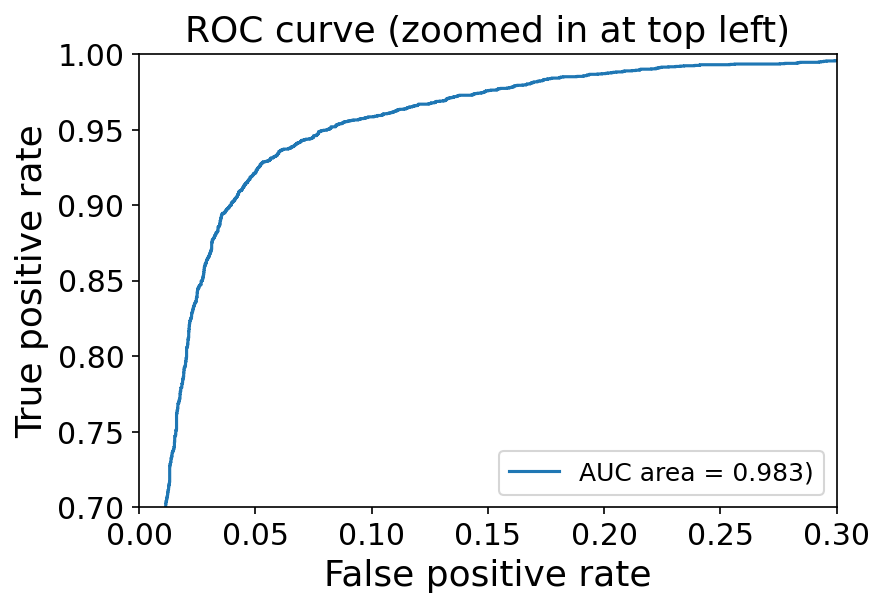

In [52]:
func_dl.draw_loss_accuracy_curves(history, project_name)
func_dl.confusion_matrix(model, test_img, test_label, nClasses)
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

In [53]:
print("Fine tuning by MobileNet_v1 model ...")
batch_size = 32
epochs = 10
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

base_model.trainable=True
model.summary()

Fine tuning by MobileNet_v1 model ...
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [54]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy', metrics=['accuracy', func_dl.f1_m, func_dl.precision_m, func_dl.recall_m])

In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

Epoch 1/10
413/413 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9721 - f1_m: 0.9721 - precision_m: 0.9725 - recall_m: 0.9718
Epoch 00001: val_accuracy improved from -inf to 0.92344, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5
413/413 [==============================] - 80s 194ms/step - loss: 0.0824 - accuracy: 0.9721 - f1_m: 0.9721 - precision_m: 0.9725 - recall_m: 0.9718 - val_loss: 0.2064 - val_accuracy: 0.9234 - val_f1_m: 0.9234 - val_precision_m: 0.9238 - val_recall_m: 0.9230
Epoch 2/10
413/413 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9746 - f1_m: 0.9746 - precision_m: 0.9747 - recall_m: 0.9745
Epoch 00002: val_accuracy improved from 0.92344 to 0.92753, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5
413/413 [==============================] - 80s 


--- Confusion matrix for test data ---

3 classes label: 0-True del; 1-True dip; 2-True dup


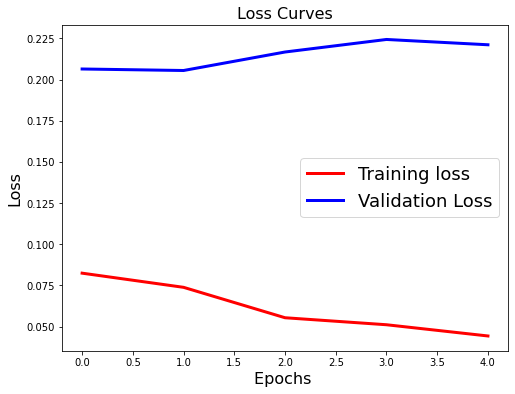

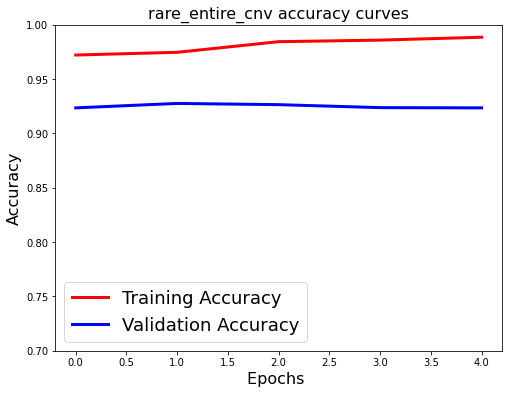

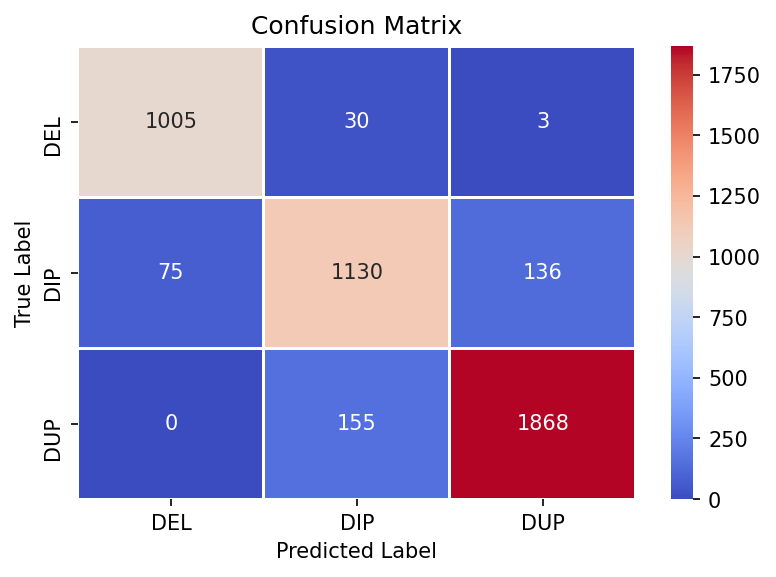


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1038
           1       0.86      0.84      0.85      1341
           2       0.93      0.92      0.93      2023

    accuracy                           0.91      4402
   macro avg       0.91      0.91      0.91      4402
weighted avg       0.91      0.91      0.91      4402



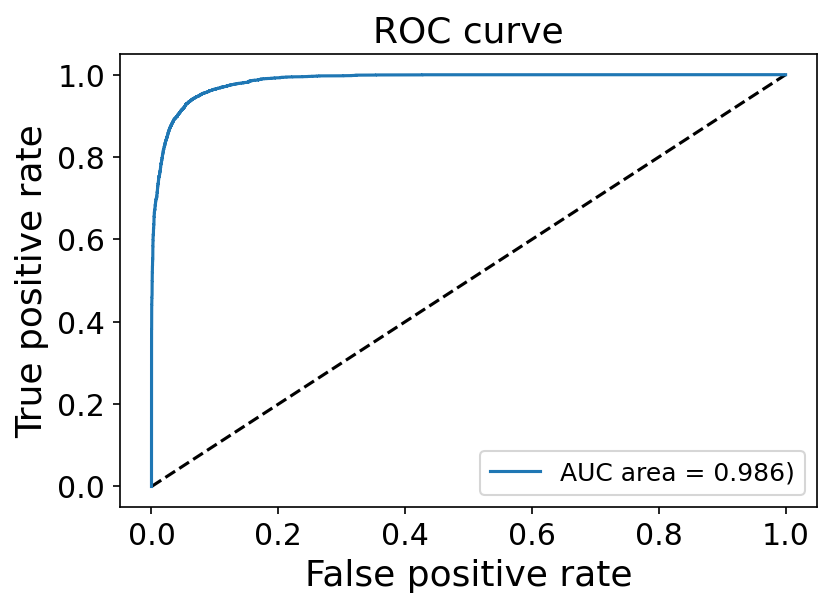

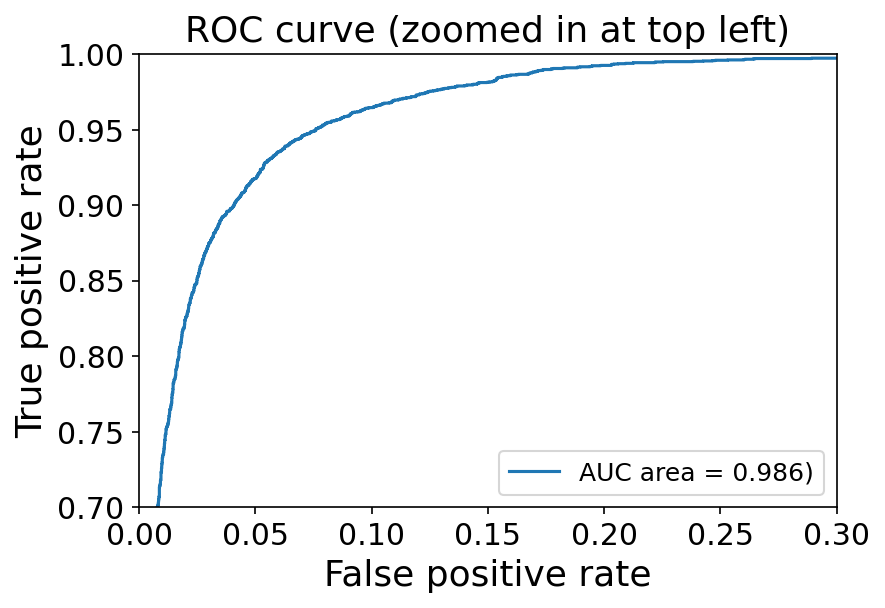

In [56]:
func_dl.draw_loss_accuracy_curves(history, project_name)
func_dl.confusion_matrix(model, test_img, test_label, nClasses)
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

### check the predict performance in different target numbers categories

In [179]:
min_win = 3
max_win = 4
selected_test_df, selected_test_img, selected_test_label = func_dl.fetch_df_by_wins(test_cnv_info_df, test_img, test_label, min_win, max_win)

There is/are 902 CNVs with number of targets/windows between 3 and 4.


level_0                                                                        4
index                                                                      21068
Unnamed: 0                                                                 21068
CHR                                                                            1
PRED_START                                                              46609654
PRED_END                                                                46615076
TYPE                                                                         DUP
SAMPLE                                                                 SP0121823
CANOES_RT                                                                      0
CLAMMS_RT                                                                      0
XHMM_RT                                                                        1
NUM_OVERLAPS_RT                                                                1
RD_PROP_RT                  

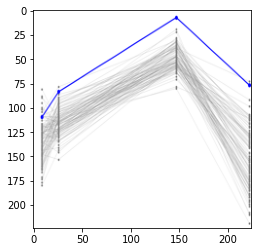

In [180]:
print(selected_test_df.iloc[0,:])
print(selected_test_label[0])
func_dl.showImg(selected_test_img[0])

In [181]:
model.evaluate(test_img, test_label)

138/138 [==============================] - 5s 34ms/step - loss: 0.2630 - accuracy: 0.9094 - f1_m: 0.9090 - precision_m: 0.9091 - recall_m: 0.9089


[0.26295235753059387,
 0.9093593955039978,
 0.9090033173561096,
 0.9091183543205261,
 0.9088919162750244]

In [216]:
min_win = 2
max_win = 20
selected_test_df, selected_test_img, selected_test_label = func_dl.fetch_df_by_wins(test_cnv_info_df, test_img, test_label, min_win, max_win)
model.evaluate(selected_test_img, selected_test_label)

There is/are 3735 CNVs with number of targets/windows between 2 and 20.
117/117 [==============================] - 4s 33ms/step - loss: 0.2905 - accuracy: 0.8985 - f1_m: 0.8983 - precision_m: 0.8984 - recall_m: 0.8982


[0.2905120253562927,
 0.8985274434089661,
 0.8983179330825806,
 0.8984492421150208,
 0.8981907367706299]

- Predict the same test data by split CNV trained model

In [208]:
split_model_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_cnv_3classes_MobileNet_v1_3classes_fold3.h5'
custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}
split_model = keras.models.load_model(split_model_path, custom_objects=custom_objects)

In [217]:
split_model.evaluate(selected_test_img, selected_test_label)

117/117 [==============================] - 4s 33ms/step - loss: 0.4977 - accuracy: 0.7622 - f1_m: 0.7624 - precision_m: 0.7640 - recall_m: 0.7608


[0.4977484345436096,
 0.7622489929199219,
 0.7623938322067261,
 0.7640392780303955,
 0.7607998847961426]

### ROC curve for multiple pre-trained models

In [ ]:
print(project_name, model_name)
model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

In [ ]:
## Load pre-calculated model
custom_objects = {"f1_m":f1_m, "precision_m":precision_m, "recall_m":recall_m}

model_name = 'CNN_model'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
common_cnn_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'MobileNet_v1'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
MobileNet_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'ResNet50'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
ResNet50_model = keras.models.load_model(model_path, custom_objects=custom_objects)

In [ ]:
fpr_MobileNet, tpr_MobileNet, thresholds_MobileNet, auc_MobileNet = pred_roc_data(MobileNet_model, test_img, test_label)
fpr_ResNet50,  tpr_ResNet50,  thresholds_ResNet50,  auc_ResNet50  = pred_roc_data(ResNet50_model,  test_img, test_label)
fpr_common_cnn,tpr_common_cnn,thresholds_common_cnn,auc_common_cnn= pred_roc_data(common_cnn_model,test_img, test_label)

In [ ]:
plt.figure(1,dpi=150)
plt.tick_params(labelsize="x-large")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_MobileNet, tpr_MobileNet, label='MobileNet_v1(area = {:.3f})'.format(auc_MobileNet))
plt.plot(fpr_ResNet50,  tpr_ResNet50,  label='ResNet50 (area = {:.3f})'.format(auc_ResNet50))
plt.plot(fpr_common_cnn,tpr_common_cnn,label='Common CNN (area = {:.3f})'.format(auc_common_cnn))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2,dpi=150)
plt.tick_params(labelsize="x-large")
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_MobileNet, tpr_MobileNet, label='MobileNet_v1(area = {:.3f})'.format(auc_MobileNet))
plt.plot(fpr_ResNet50,  tpr_ResNet50,  label='ResNet50 (area = {:.3f})'.format(auc_ResNet50))
plt.plot(fpr_common_cnn,tpr_common_cnn,label='Common CNN (area = {:.3f})'.format(auc_common_cnn))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve (zoomed in at top left)',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()

In [ ]:
test_img.shape, test_label.shape

In [ ]:
fpr,tpr,thresholds,auc= pred_roc_data(model,test_img, test_label)

In [ ]:
plt.figure(1,dpi=150)
plt.tick_params(labelsize="x-large")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='MobileNet_v1(area = {:.3f})'.format(auc))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()

- Calculate model metrics (F1-score). TODO: calcualte f1-score in different categories

In [ ]:
print("Model_name: common_cnn_model")
loss, accuracy, f1_score, precision, recall = common_cnn_model.evaluate(test_img, test_label)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
print("Model_name: MobileNet")
loss, accuracy, f1_score, precision, recall = MobileNet_model.evaluate(test_img, test_label)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
print("Model_name: ResNet50")
loss, accuracy, f1_score, precision, recall = ResNet50_model.evaluate(test_img, test_label)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
i=random.randrange(len(test_img))
#i=random.choice(test_output_df[test_output_df['Pred_status']=='Wrong'].index)
showImg(test_img[i]), 
print(test_label[i],  test_cnv_info_df.iloc[i,:])

In [ ]:
print(project_name)
time_stamp = datetime.datetime.now()
time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
print(time_str)

- Confusion matrix

In [ ]:
## Load pre-calculated model
custom_objects = {"f1_m":f1_m, "precision_m":precision_m, "recall_m":recall_m}
nClasses = 4

model_name = 'CNN_model'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
common_cnn_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'MobileNet_v1'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
MobileNet_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'ResNet50'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
ResNet50_model = keras.models.load_model(model_path, custom_objects=custom_objects)

In [ ]:
test_pred = model.predict(test_img)

In [ ]:
# output model metrics
model_metric_list = []
model_metric_list.append(model_name)
model_metric_list.append(["loss:", loss]) 
model_metric_list.append(["accuracy:", accuracy])
model_metric_list.append(["precision:", precision])
model_metric_list.append(["recall:", recall])
model_metric_list.append(["f1_score:", f1_score])
output_to_file(model_metric_list, model_dir + "model_metrics_" + model_name + ".txt")

## K-fold cross validation

In [218]:
model_dir = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/'
model_name='MobileNet_v1'

seed = 6666
num_folds = 5
# Define the K-fold Cross Validator
#kfold = KFold(n_splits=num_folds, shuffle=True)
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

In [ ]:
VALIDATION_ACCURACY, VALIDATION_LOSS = [], []
tpr_list, tpr_interp_list, fpr_list, auc_list = [], [], [], []
mean_fpr = np.linspace(0, 1, 100)

nClasses = 3

# K-fold Cross Validation model evaluation

train_val_img, test_img, train_val_label, test_label = train_test_split(combined_img,
                                                                      combined_label,
                                                                      test_size=0.2,
                                                                      shuffle=True,
                                                                      random_state=seed)
test_label_one_hot = to_categorical(test_label)

fold_num = 0
for train_index, val_index in kfold.split(train_val_img, train_val_label):
    print('------------------------------------------------------------------------')
    func.showDateTime()
    print('Training for fold %d ...'%fold_num)
    print("num_index",len(train_index), len(val_index))
   
    train_img  = train_val_img[train_index]
    train_label_one_hot = to_categorical(train_val_label[train_index])
    
    val_img  = train_val_img[val_index]
    val_label_one_hot = to_categorical(train_val_label[val_index])
    
#     train_img, val_img, train_label_one_hot, val_label_one_hot = train_test_split(train_val_img,
#                                                                   train_val_label_one_hot,
#                                                                   test_size=0.25,
#                                                                   shuffle=True,
#                                                                   random_state=seed)
    
    print("Combined:", combined_img.shape, combined_label_one_hot.shape)
    print("Train:", train_img.shape, train_label_one_hot.shape)
    print("Validation:", val_img.shape, val_label_one_hot.shape)
    print("Test:", test_img.shape, test_label_one_hot.shape)
    
    # CREATE and COMPILE NEW MODEL
    model_name='MobileNet_v1'
    print("Model name: %s"%model_name)
    model = func_dl.cnn_model(model_name, nClasses)
    
    model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses)+ "classes_fold" +str(fold_num)+"_0221.h5"
    
    # CREATE CALLBACKS
    batch_size = 32
    epochs = 50
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    checkpoint = ModelCheckpoint(model_file,
                         monitor='val_accuracy',
                         mode='max', 
                         verbose=1, 
                         save_best_only=True)
    callbacks_list = [checkpoint]
    
    # FIT THE MODEL
    print("Fit the model ...")
    history = model.fit(train_img, train_label_one_hot,
                        batch_size=batch_size, 
                        epochs=epochs, verbose=1, 
                        validation_data=(val_img, val_label_one_hot), 
                        callbacks=[es, checkpoint])
    ## easy to exhaust the memory by using "validation_split = 0.2"

    # LOAD BEST MODEL to evaluate the performance of the model
    print("Load weights...")
    model.load_weights(model_file)

    print("Evaluate ...")
    results = model.evaluate(test_img, test_label_one_hot)
    results = dict(zip(model.metrics_names,results))
    print(results)
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    fpr_roc, tpr_roc, thresholds_roc, auc_roc = func_dl.pred_roc_data(model, test_img, test_label_one_hot)    

    interp_tpr = np.interp(mean_fpr, fpr_roc, tpr_roc)
    interp_tpr[0] = 0.0
    
    tpr_list.append(tpr_roc)
    tpr_interp_list.append(interp_tpr)
    fpr_list.append(fpr_roc)
    auc_list.append(auc_roc)
    
    tf.keras.backend.clear_session()
    fold_num += 1

------------------------------------------------------------------------
[2021.02.21-11:23:20]
Training for fold 0 ...
num_index 14084 3522
Combined: (22008, 224, 224, 3) (22008, 3)
Train: (14084, 224, 224, 3) (14084, 3)
Validation: (3522, 224, 224, 3) (3522, 3)
Test: (4402, 224, 224, 3) (4402, 3)
Model name: MobileNet_v1
Fit the model ...
Epoch 1/50
441/441 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.8407 - f1_m: 0.8220 - precision_m: 0.8455 - recall_m: 0.8073
Epoch 00001: val_accuracy improved from -inf to 0.88870, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_3classes_fold0_0221.h5
441/441 [==============================] - 79s 179ms/step - loss: 0.4566 - accuracy: 0.8407 - f1_m: 0.8220 - precision_m: 0.8455 - recall_m: 0.8073 - val_loss: 0.3443 - val_accuracy: 0.8887 - val_f1_m: 0.8850 - val_precision_m: 0.8860 - val_recall_m: 0.8840
Epoch 2/50
440/441 [============================>.] - E

Number of folds: 3
0.9810984237283116
ROC curve output plot to: /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_roc_curve.png


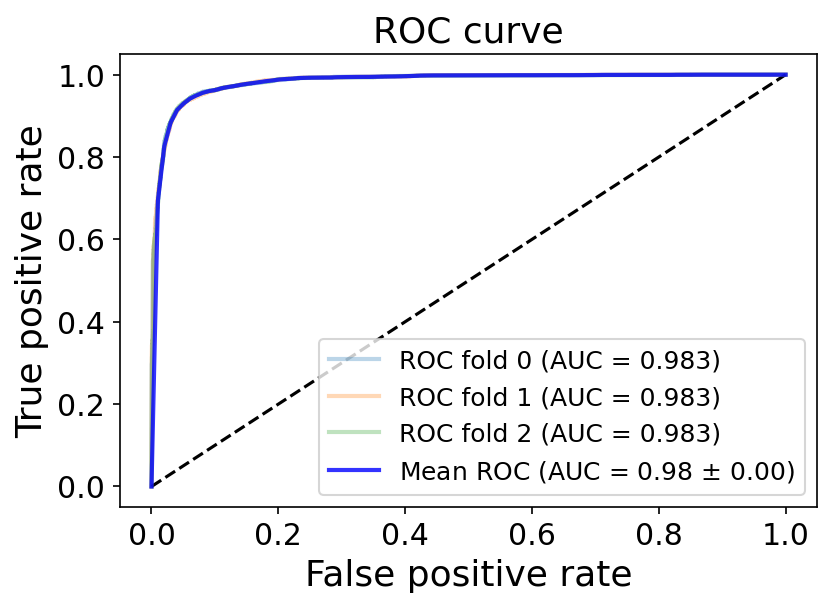

[2021.02.19-07:29:03]
Zoomed ROC curve output plot to: /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5rare_entire_cnv_MobileNet_v1_roc_curve_zoom.png


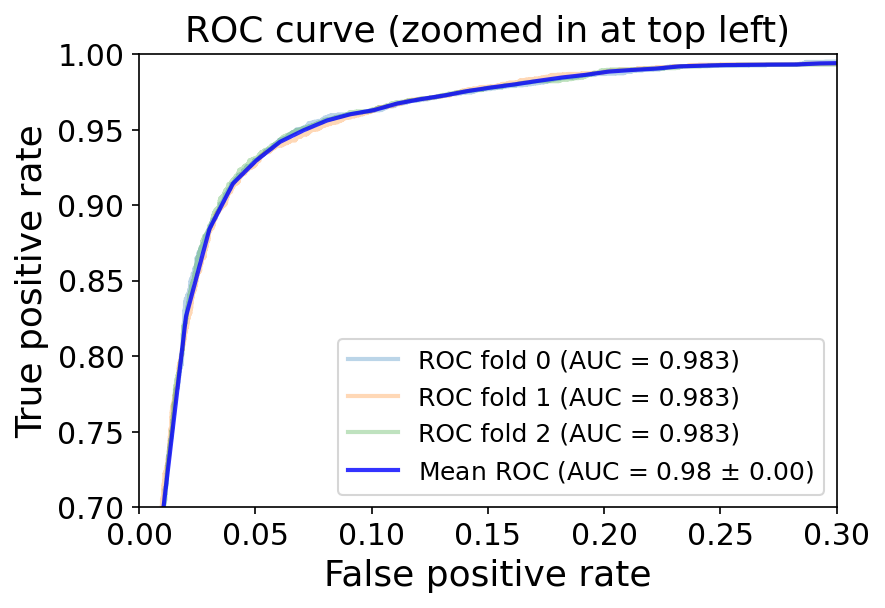

In [248]:
output_image_file = model_dir + project_name + "_" + model_name + "_roc_curve.png"
func_dl.draw_kfold_roc_curve(tpr_list, tpr_interp_list, fpr_list, auc_list, output_image_file)


--- Confusion matrix for test data ---

3 classes label: 0-True del; 1-True dip; 2-True dup


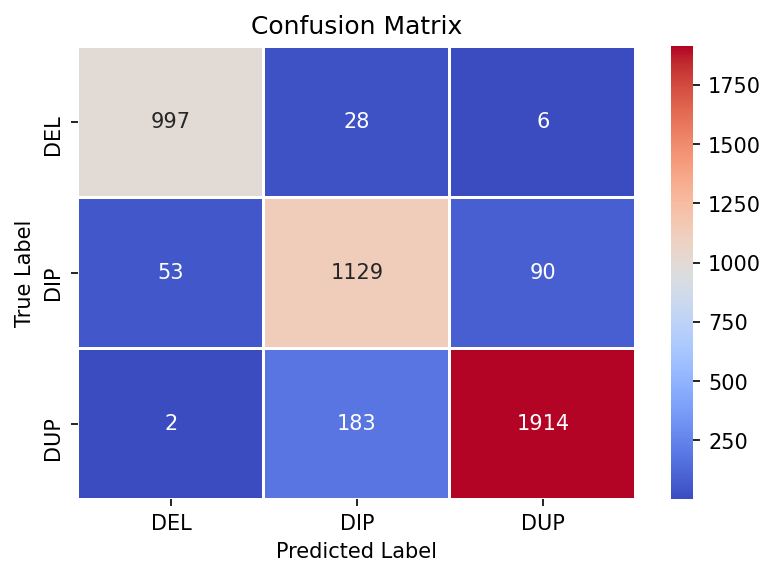


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1031
           1       0.84      0.89      0.86      1272
           2       0.95      0.91      0.93      2099

    accuracy                           0.92      4402
   macro avg       0.91      0.92      0.92      4402
weighted avg       0.92      0.92      0.92      4402



In [249]:
model_file = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_3classes_fold2_0218.h5'
custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}

model = keras.models.load_model(model_file, custom_objects=custom_objects)
func_dl.confusion_matrix(model, test_img, test_label, nClasses=3)

In [163]:
test_img.shape,test_label.shape

((4402, 224, 224, 3), (4402,))

### TODO:
- Check the performance on different size categories on test data firstly and by k-fold cross validation secondly. 

## Reference:
- Load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy demo: https://zhuanlan.zhihu.com/p/51889181
- Transfer learning and fine tune: 
    - 讲解：https://zhuanlan.zhihu.com/p/26693647
    - 官方教程：https://www.geek-book.com/src/docs/keras/keras/keras.io/guides/transfer_learning/index.html
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
- F1 score: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model